## Семинар 3: "Методы оптимизации"


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from tqdm.auto import tqdm
from torch import nn
from matplotlib.pyplot import cm
from torchvision import datasets, transforms
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.


### Часть 1: Реализация методов


Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.


<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>


In [4]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass


In [5]:
def optimize_function(fn, optim, optim_args, start_point, num_iter=50):
    weights = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weights], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, "pre_step"):
            optim.pre_step()
        loss = fn(weights[0], weights[1])
        points.append(weights.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [6]:
from matplotlib.colors import LogNorm

def compare_optimizers(
    fn,
    optim_list,
    start_point,
    x_range=(-5, 5),
    y_range=(-5, 5),
    xstep=0.2,
    ystep=0.2,
    minima=None,
    num_iter = 50,
):
    xmin, xmax = x_range
    ymin, ymax = y_range
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = fn(torch.from_numpy(x), torch.from_numpy(y))
    z = z.detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    if minima:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    colors = cm.rainbow(np.linspace(0, 1, len(optim_list)))
    
    name_losses = {}
    
    for c, (name, optim, args) in zip(colors, optim_list):
        points, losses = optimize_function(fn, optim, args, start_point, num_iter)
        ax.quiver(
            points[:-1, 0], points[:-1, 1],  
            points[1:, 0] - points[:-1, 0], points[1:, 1] - points[:-1, 1], 
            scale_units='xy', angles='xy', scale=1, color=c,
            label=name
        )
        name_losses[name] = losses
    
    ax.legend()
    plt.show()
    
    plt.figure()
    x = np.arange(0, num_iter)
    for name, losses in name_losses.items():
        plt.plot(x, losses.numpy(), label=name)
    
    plt.legend()
    plt.show()
        
        

In [7]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        

In [8]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in self.params]
        self.gamma = gamma
        
    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= self.lr * v
                
                

In [9]:
# v = gamma v - lr * dJ/dw (w - gamma * v)

class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in self.params]
        self.gamma = gamma
        
    def pre_step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                p -= self.gamma * v
        
    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                p += self.gamma * v
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= v
                
                

In [10]:
class RMSProp(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9, eps=1e-9):
        super().__init__(params)
        self.lr = lr
        self.G = [torch.zeros_like(p) for p in self.params]
        self.gamma = gamma
        self.eps = eps

    def step(self):
        with torch.no_grad():
            for g, p in zip(self.G, self.params):
                if p.grad is None:
                    continue
                g.copy_(self.gamma * g + (1 - self.gamma) * p.grad**2)
                p -= self.lr / torch.sqrt(g + self.eps) * p.grad


In [11]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1.0, eps=1e-8):
        super().__init__(params)
        self.params_G = [torch.zeros_like(param) for param in self.params]
        self.needs_pre_step = True

        self.lr = lr
        self.eps = eps

    def step(self):
        with torch.no_grad():
            for param, param_G in zip(self.params, self.params_G):
                # Tensor.grad: This attribute is None by default
                # and becomes a Tensor the first time a call to backward() computes gradients for self.
                # т.е. в pre_step нельзя вынести, т.к. перед его вызовом нет backward() и соотв param.grad is None
                if self.needs_pre_step:
                    param_G.set_(param.grad**2)
                else:
                    param_G.set_(param_G + param.grad**2)

                step = self.lr / (param_G + self.eps).sqrt() * param.grad

                param.set_(param - step)
            self.needs_pre_step = False


In [12]:
class Adadelta(Optimizer):
    def __init__(self, params, lr=1.0, gamma=0.9, eps=1e-8):
        super().__init__(params)
        self.params_G = [torch.zeros_like(param) for param in self.params]

        self.needs_pre_step = True

        self.lr = lr
        self.gamma = gamma
        self.eps = eps

    def step(self):
        sum_step = 0
        num_params = 0
        with torch.no_grad():
            for param, param_G in zip(self.params, self.params_G):
                # идентично предыдущему
                if self.needs_pre_step:
                    param_G.set_(param.grad**2)
                else:
                    param_G.set_(
                        self.gamma * param_G + (1.0 - self.gamma) * param.grad**2
                    )

                step = self.lr / (param_G + self.eps).sqrt() * param.grad

                sum_step += step.sum()
                num_params += step.numel()

                param -= step

            self.lr = self.gamma * self.lr + (1.0 - self.gamma) * sum_step / num_params
            self.needs_pre_step = False


In [13]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params)
        self.params_m = [torch.zeros_like(param) for param in self.params]
        self.params_v = [torch.zeros_like(param) for param in self.params]

        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

    def step(self):
        with torch.no_grad():
            for param, m, v in zip(self.params, self.params_m, self.params_v):

                m.set_(self.beta1 * m + (1.0 - self.beta1) * param.grad)
                v.set_(self.beta2 * v + (1.0 - self.beta2) * param.grad**2)

                m_ = m / (1 - self.beta1)
                v_ = v / (1 - self.beta2)

                param.set_(param - (self.lr / (v_.sqrt() + self.eps) * m_))


<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>


In [14]:
def F1(x, y):
    return x**2 + y**2


def F2(x, y):
    return (
        (1.5 - x + x * y) ** 2
        + (2.25 - x + x * y**2) ** 2
        + (2.625 - x + x * y**3) ** 2
    )


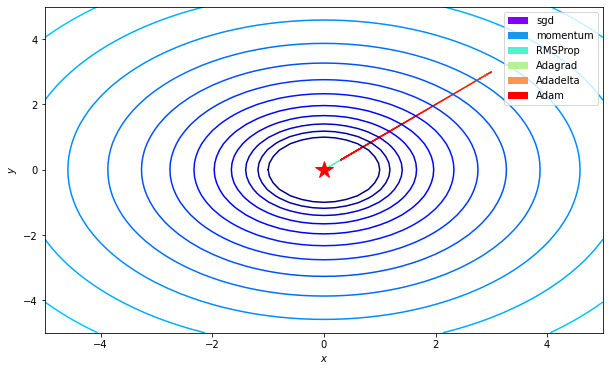

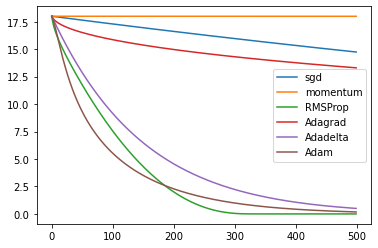

In [15]:
compare_optimizers(
    F1,
    [
        ("sgd", SGD, dict(lr=1e-4)),
        ("momentum", Momentum, dict(lr=1e-4)),
        # ("nag", NAG, dict(lr=1e-3, gamma=0.9)), # ломает картинку с графиками
        ("RMSProp", RMSProp, dict(lr=1e-2)),
        ("Adagrad", Adagrad, dict(lr=1e-2, eps=1e-5)),
        ("Adadelta", Adadelta, dict(lr=1e-2, gamma=0.9, eps=1e-8)),
        ("Adam", Adam, dict(lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8)),
    ],
    start_point=[3, 3],
    minima=(0, 0),
    num_iter=500,
)


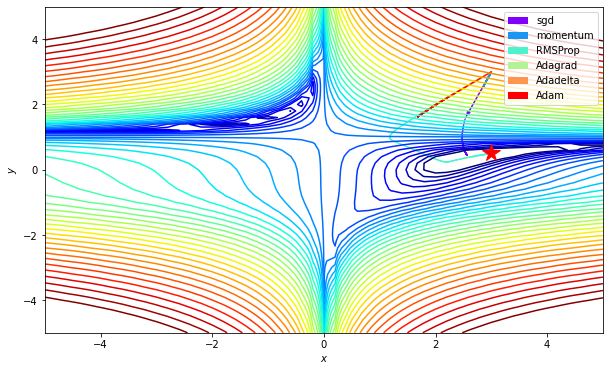

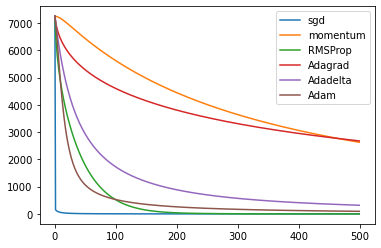

In [16]:
compare_optimizers(
    F2,
    [
        ("sgd", SGD, dict(lr=1e-4)),
        ("momentum", Momentum, dict(lr=1e-4)),
        # ("nag", NAG, dict(lr=1e-3, gamma=0.9)), # ломает картинку с графиками
        ("RMSProp", RMSProp, dict(lr=1e-2)),
        ("Adagrad", Adagrad, dict(lr=1e-2, eps=1e-5)),
        ("Adadelta", Adadelta, dict(lr=1e-2, gamma=0.9, eps=1e-8)),
        ("Adam", Adam, dict(lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8)),
    ],
    start_point=[3, 3],
    minima=(3, 0.5),
    num_iter=500,
)


<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>


In [17]:
def F3(x, y):
    return x**2 * torch.sin(x) + y**2 * torch.sin(y)


C:\Temp/ipykernel_4624/1455231318.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


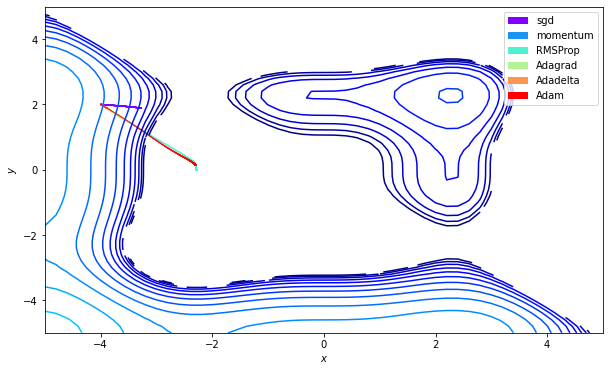

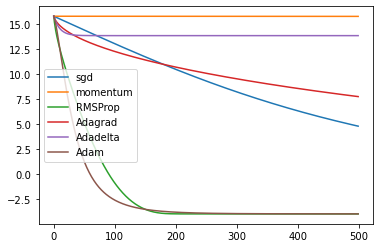

In [18]:
compare_optimizers(
    F3,
    [
        ("sgd", SGD, dict(lr=1e-4)),
        ("momentum", Momentum, dict(lr=1e-4)),
        # ("nag", NAG, dict(lr=1e-3, gamma=0.9)), # ломает картинку с графиками
        ("RMSProp", RMSProp, dict(lr=1e-2)),
        ("Adagrad", Adagrad, dict(lr=1e-2, eps=1e-5)),
        ("Adadelta", Adadelta, dict(lr=1e-2, gamma=0.9, eps=1e-8)),
        ("Adam", Adam, dict(lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8)),
    ],
    start_point=[-4, 2],
    num_iter=500,
)


<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>


In [19]:
def F4(x, y):
    return x**2 * torch.sin(x**2) + y**2 * torch.sin(y**2)


C:\Temp/ipykernel_4624/1455231318.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


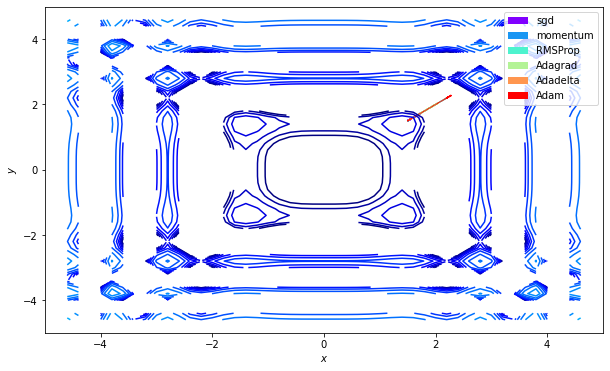

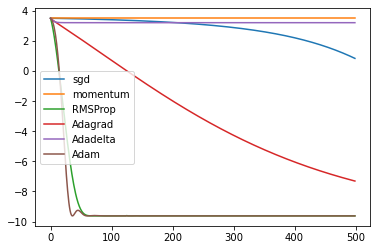

In [20]:
compare_optimizers(
    F4,
    [
        ("sgd", SGD, dict(lr=1e-4)),
        ("momentum", Momentum, dict(lr=1e-4)),
        # ("nag", NAG, dict(lr=1e-3, gamma=0.9)), # ломает картинку с графиками
        ("RMSProp", RMSProp, dict(lr=1e-2)),
        ("Adagrad", Adagrad, dict(lr=1e-2, eps=1e-5)),
        ("Adadelta", Adadelta, dict(lr=1e-2, gamma=0.9, eps=1e-8)),
        ("Adam", Adam, dict(lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8)),
    ],
    start_point=[1.5, 1.5],
    num_iter=500,
)


В 3 и 4 нет глобальных минимумов, всё так или иначе стремиться скатиться в локальные, у Adam с RMSProp это выходит куда лучше и быстрее в общем случае (в 2 sgd очень быстро сходится но в той же 4 ему очень тяжело)


### Часть 2: Обучение нейронной сети


<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>


In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.MNIST(".", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(".", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [22]:
def process_model(model, loss, optimizer, epochs):
    train_losses = []
    test_losses = []

    train_accuracy = []
    test_accuracy = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for X, y in train_loader:
            model.zero_grad()
            output = model.forward(X)

            batch_loss = loss.forward(output, y)
            total_loss += batch_loss.item()

            predicted = np.argmax(output.detach().numpy(), axis=1)
            total += y.shape[0]
            correct += (predicted == y.numpy()).sum()

            batch_loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracy.append(correct / total)
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_loader:
                output = model.forward(X)

                batch_loss = loss.forward(output, y)
                total_loss += batch_loss.item()

                predicted = np.argmax(output.detach().numpy(), axis=1)
                total += y.shape[0]
                correct += (predicted == y.numpy()).sum()

            avg_loss = total_loss / len(test_loader)
            test_losses.append(avg_loss)
            test_accuracy.append(correct / total)

    return train_losses, test_losses, train_accuracy, test_accuracy


In [23]:
class ConvClassifier(nn.Module):
    def __init__(self, image_size, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 3, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 16, 3, padding=1)
        self.fc1 = nn.Linear(image_size * image_size, 120)
        self.fc2 = nn.Linear(120, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x


In [24]:
def print_plots(train_losses, test_losses, train_accuracy, test_accuracy):
    plt.plot(train_losses, label="train loss")
    plt.plot(test_losses, label="test loss")
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label="train accuracy")
    plt.plot(test_accuracy, label="test accuracy")
    plt.legend()
    plt.show()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>


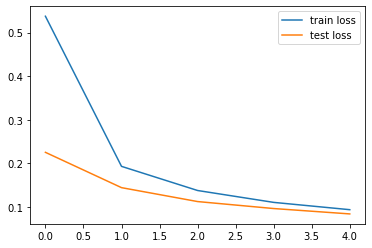

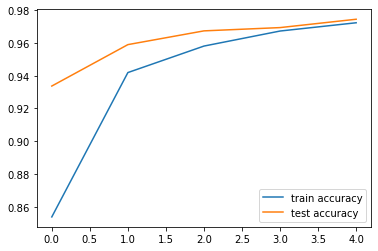

In [25]:
model = ConvClassifier(image_size=28, channels=1)
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

print_plots(*process_model(model, loss, optimizer, epochs))


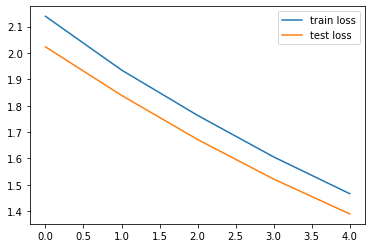

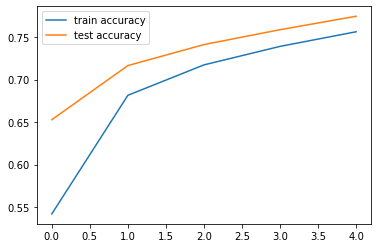

In [26]:
model = ConvClassifier(image_size=28, channels=1)
loss = nn.NLLLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-4)
epochs = 5

print_plots(*process_model(model, loss, optimizer, epochs))

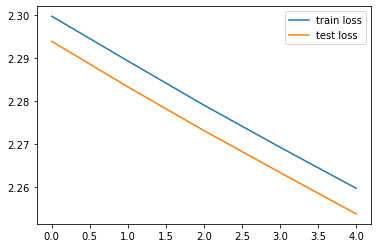

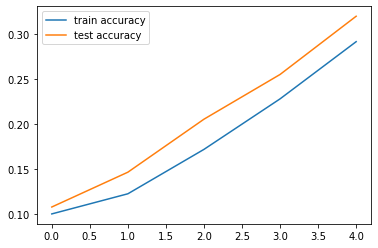

In [27]:
model = ConvClassifier(image_size=28, channels=1)
loss = nn.NLLLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1e-4)
epochs = 5

print_plots(*process_model(model, loss, optimizer, epochs))

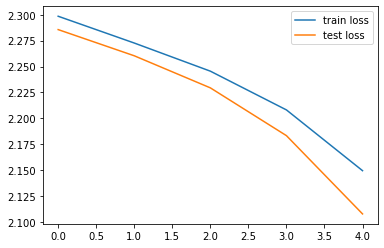

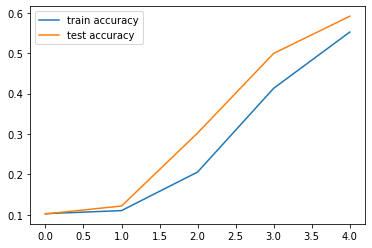

In [28]:
model = ConvClassifier(image_size=28, channels=1)
loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
epochs = 5

print_plots(*process_model(model, loss, optimizer, epochs))

Adam классный, за 5 эпох с lr=1e-4 успевает хорошо натренировать модель, остальные оптимизиторы за такое же число эпох с таким же лернинг рейтом не успевают добиться такого же результата, можно было бы учить подольше и/или поиграться с лернинг рейтом

#### Feedback (опционально)


Здесь вы можете оставить список опечаток из лекции или семинара:


Здесь вы можете оставить комментарии по лекции или семинару:
